In [1]:
import os
# os.environ['NUMBA_ENABLE_CUDASIM'] = '1'
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# print(os.environ['NUMBA_ENABLE_CUDASIM'])

import numpy as np
# from numba.core.errors import NumbaPerformanceWarning
import torch
torch.set_grad_enabled(False)
import random
import warnings

# filter out numba performance warning
# warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

from evolution import gworld
# from evolution import algorithms
from evolution import config
from evolution.visual import brain_visual

%load_ext autoreload
%autoreload 2

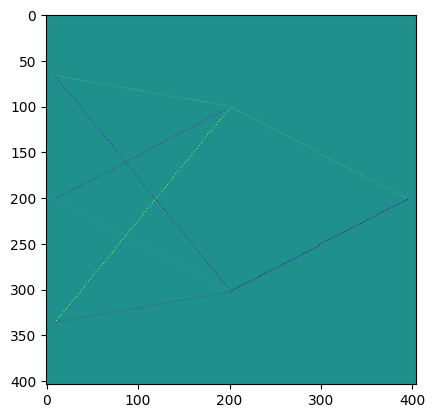

In [12]:
# Example usage
# Assuming activations and weights are lists of tensors
# Example setup for testing:
activations = [torch.tensor([-0.5, 0.3, 0.7]), torch.tensor([0.2, -0.8]), torch.tensor([0.6])]
weights = [torch.tensor([[0.2, -0.4], [-0.3, 0.1], [0.5, -0.2]]), torch.tensor([[0.3], [-0.7]])]

import matplotlib.pyplot as plt

image_tensor,indices = brain_visual.generate_image_and_indices(activations, weights)
img = image_tensor.numpy()
plt.imshow(img)

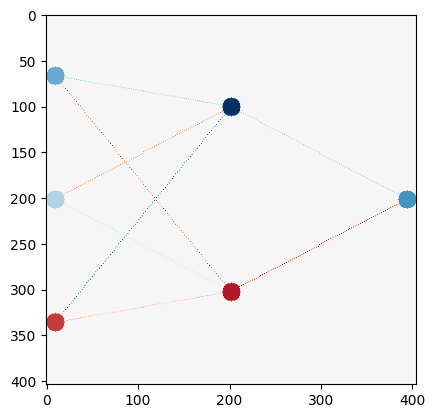

In [17]:
activations = [torch.tensor([0.5, 0.3, -0.7]), torch.tensor([1.0, -0.8]), torch.tensor([0.6])]
brain_visual.fast_update_image(image_tensor, indices, activations)
plt.imshow(image_tensor.numpy(), cmap='RdBu')

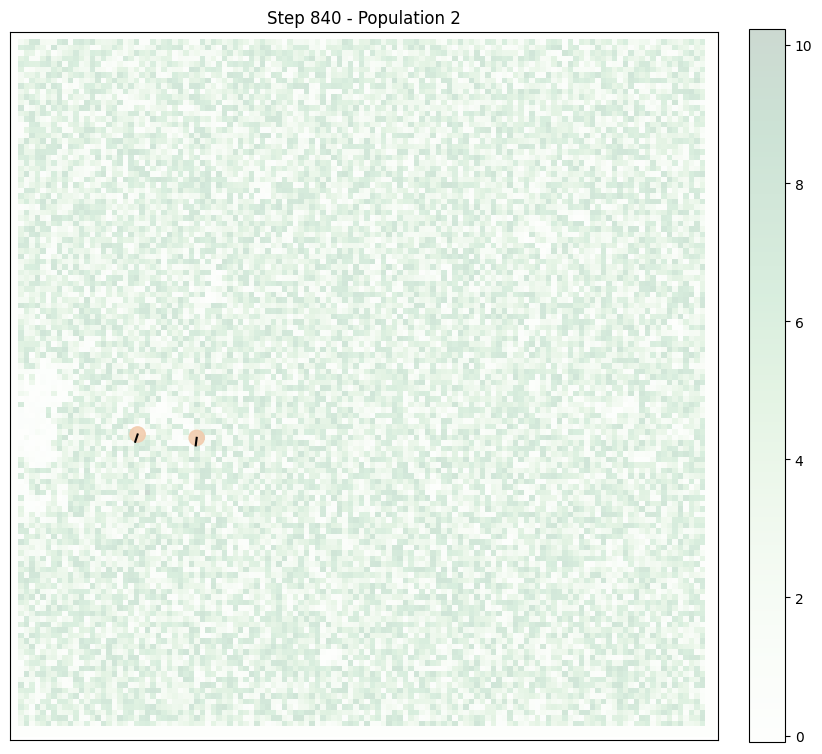

Mass extinction!


In [6]:
cfg = config.Config(food_sight=2, max_creatures=2048, food_cover_decr=0.01, attack_dist_bonus=1)
_, game = gworld.main(cfg)

# Benchmark with CUDA-python rewrite

In [5]:
results = gworld.benchmark()
print(sum(results.values()))
results

         1938535 function calls (1925805 primitive calls) in 3.118 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      512    0.009    0.000    3.118    0.006 /home/rob/Data/JACK_HACKATHON/evolution/evolution/world.py:236(step)
     5632    0.020    0.000    2.629    0.000 /home/rob/Data/JACK_HACKATHON/evolution/evolution/world.py:29(wrapper)
13252/5144    0.021    0.000    1.626    0.000 /home/rob/anaconda3/envs/jack/lib/python3.10/site-packages/torch/_tensor.py:868(__format__)
     4621    0.004    0.000    1.609    0.000 {function Tensor.__format__ at 0x78feb1acf880}
     4621    0.008    0.000    1.605    0.000 /home/rob/anaconda3/envs/jack/lib/python3.10/site-packages/torch/_tensor.py:420(__repr__)
     4621    0.032    0.000    1.597    0.000 /home/rob/anaconda3/envs/jack/lib/python3.10/site-packages/torch/_tensor_str.py:633(_str)
     4621    0.091    0.000    1.501    0.000 /home/rob/anaconda3/envs/jack/lib/pyth

defaultdict(float,
            {'compute_grid_setup': 124.5016965419054,
             'trace_rays_grid': 56.72521595656872,
             'collect_stimuli': 57.4202880859375,
             'think': 79.87078426778316,
             'move_creatures': 1145.432578086853,
             'compute_gridded_attacks': 56.38787201792002,
             'do_attacks': 220.24182379245758,
             'creatures_reproduce': 52.996928073465824,
             'creatures_eat': 442.59039998054504,
             'grow_food': 157.47158429026604})

# Food Grid Death Test

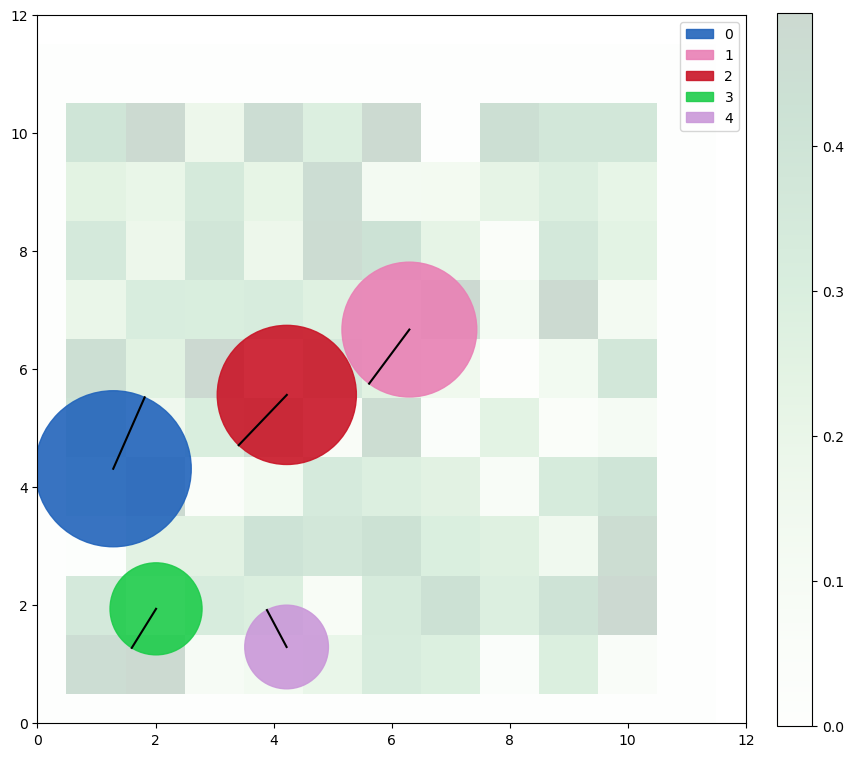

In [ ]:
game = gworld.GWorld(5,10,10)
game.food_grid /= 10
game.visualize(None,show_rays=False)

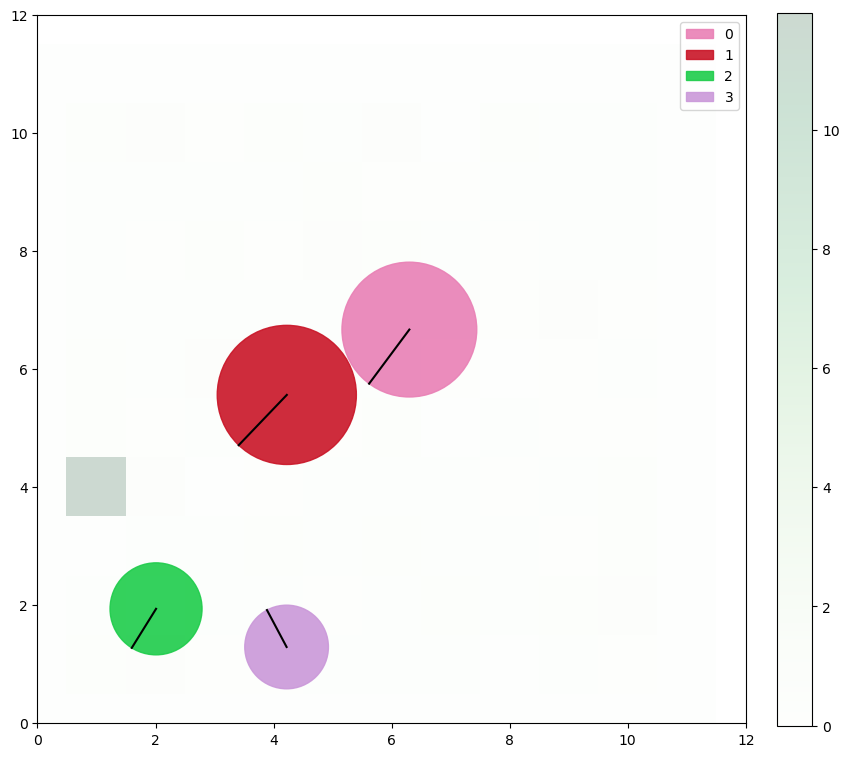

In [ ]:
game.creatures.healths[0] -= 100
game.creatures.kill_dead(game.food_grid)
game.visualize(None,show_rays=False)

# Benchmarking Gridded vs. Non-gridded attacking

In [ ]:
import cProfile
from pstats import SortKey
import io, pstats

# gridded attacks vs regular

torch.manual_seed(1)

pr3 = cProfile.Profile()
pr3.enable()
time_res3 = gworld.main()
pr3.disable()
s3 = io.StringIO()
sortby = SortKey.CUMULATIVE
ps3 = pstats.Stats(pr3, stream=s3).sort_stats(sortby)
ps3.print_stats()
print(s3.getvalue())
time_res3

         4449576 function calls (4367117 primitive calls) in 13.063 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   13.063    6.532 /home/rob/anaconda3/envs/jack/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3397(run_code)
        2    0.000    0.000   13.063    6.532 {built-in method builtins.exec}
        1    0.026    0.026   13.063   13.063 /home/rob/Data/JACK_HACKATHON/evolution/evolution/world.py:390(main)
      512    8.599    0.017    8.599    0.017 {built-in method time.sleep}
     6144    0.028    0.000    3.707    0.001 /home/rob/Data/JACK_HACKATHON/evolution/evolution/world.py:27(wrapper)
     2560    0.002    0.000    1.615    0.001 /home/rob/anaconda3/envs/jack/lib/python3.10/site-packages/numba/cuda/dispatcher.py:538(__call__)
     2560    0.008    0.000    1.613    0.001 /home/rob/anaconda3/envs/jack/lib/python3.10/site-packages/numba/cuda/dispatcher.py:674(cal

defaultdict(float,
            {'compute_grid_setup': 611.2580800056458,
             'trace_rays_grid': 434.96713572740555,
             'collect_stimuli': 86.6635837778449,
             'think': 104.63449567556381,
             'move_creatures': 210.12185630202293,
             'compute_attacks': 316.6174721121788,
             'compute_gridded_attacks': 423.1045112609863,
             'do_attacks': 481.7500144839287,
             'creatures_eat': 76.54944004118443,
             'creatures_reproduce': 461.23004806786776,
             'energy_grow': 28.397119991481304})

# Benchmarking ray tracing approaches

In [ ]:
import cProfile
from pstats import SortKey
import io, pstats

# fake ray trace

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)
pr = cProfile.Profile()
pr.enable()
time_res = gworld.main()
pr.disable()
s = io.StringIO()
sortby = SortKey.CUMULATIVE
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())
time_res

On step0, 512 creatures alive.
On step100, 16384 creatures alive.
On step200, 16384 creatures alive.
On step300, 16384 creatures alive.
On step400, 16384 creatures alive.
         3326399 function calls (3215023 primitive calls) in 136.533 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000  136.534   68.267 /home/rob/anaconda3/envs/jack/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3397(run_code)
        2    0.000    0.000  136.534   68.267 {built-in method builtins.exec}
        1    0.000    0.000  136.534  136.534 /tmp/ipykernel_254318/1946028982.py:1(<module>)
        1    0.015    0.015  136.534  136.534 /home/rob/Data/JACK_HACKATHON/evolution/evolution/world.py:204(main)
     4000    0.020    0.000  135.308    0.034 /home/rob/Data/JACK_HACKATHON/evolution/evolution/world.py:24(wrapper)
     4000    0.011    0.000  129.374    0.032 /home/rob/anaconda3/envs/jack/lib/python3.10

defaultdict(float,
            {'trace_rays': 129395.39285683632,
             'collect_stimuli': 65.91030411422253,
             'think': 203.0675523877144,
             'move_creatures': 270.4288649559021,
             'do_attacks': 3741.8604127168655,
             'creatures_eat': 70.40870405733585,
             'creatures_reproduce': 1256.668548502028,
             'energy_grow': 27.631552010774612})

In [ ]:
import cProfile
from pstats import SortKey
import io, pstats

# correct ray trace

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)
pr2 = cProfile.Profile()
pr2.enable()
time_res2 = gworld.main()
pr2.disable()
s2 = io.StringIO()
sortby = SortKey.CUMULATIVE
ps2 = pstats.Stats(pr2, stream=s2).sort_stats(sortby)
ps2.print_stats()
print(s2.getvalue())
time_res2


On step0, 512 creatures alive.


On step100, 16384 creatures alive.
On step200, 16384 creatures alive.
On step300, 16384 creatures alive.
On step400, 16384 creatures alive.
         3183758 function calls (3080387 primitive calls) in 25.168 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   25.168   12.584 /home/rob/anaconda3/envs/jack/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3397(run_code)
        2    0.000    0.000   25.168   12.584 {built-in method builtins.exec}
        1    0.014    0.014   25.168   25.168 /home/rob/Data/JACK_HACKATHON/evolution/evolution/world.py:204(main)
     4000    0.019    0.000   24.103    0.006 /home/rob/Data/JACK_HACKATHON/evolution/evolution/world.py:24(wrapper)
     4000    0.010    0.000   18.677    0.005 /home/rob/anaconda3/envs/jack/lib/python3.10/site-packages/torch/cuda/__init__.py:678(synchronize)
     4000   18.610    0.005   18.610    0.005 {built-in method torch._C

defaultdict(float,
            {'trace_rays': 18731.94690513611,
             'collect_stimuli': 60.40700840204954,
             'think': 185.20476844906807,
             'move_creatures': 253.0873914361,
             'do_attacks': 3595.720289349556,
             'creatures_eat': 69.97628791630268,
             'creatures_reproduce': 909.8484791815281,
             'energy_grow': 27.516095958650112})

In [ ]:
import cProfile
from pstats import SortKey
import io, pstats

# grid ray trace

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)
pr3 = cProfile.Profile()
pr3.enable()
time_res3 = gworld.main()
pr3.disable()
s3 = io.StringIO()
sortby = SortKey.CUMULATIVE
ps3 = pstats.Stats(pr3, stream=s3).sort_stats(sortby)
ps3.print_stats()
print(s3.getvalue())
time_res3


On step0, 512 creatures alive.
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0


/home/rob/anaconda3/envs/jack/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/rob/anaconda3/envs/jack/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.0
Pct at max 0.00012597631645250694
Pct at max 0.00012597631645250694


/home/rob/anaconda3/envs/jack/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 3 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/rob/anaconda3/envs/jack/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/rob/anaconda3/envs/jack/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 5 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/rob/anaconda3/envs/jack/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 7 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/rob/anaconda3/envs/jack/lib/python3.10/site-packages/numba/cuda/dispatcher.py:

Pct at max 0.0002519526329050139
Pct at max 0.0003149407911312673
Pct at max 0.0003779289493575208
Pct at max 0.0003779289493575208
Pct at max 0.0005039052658100278
Pct at max 0.0005039052658100278
Pct at max 0.0005039052658100278
Pct at max 0.0005039052658100278
Pct at max 0.0005039052658100278


/home/rob/anaconda3/envs/jack/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 14 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/rob/anaconda3/envs/jack/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 21 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/rob/anaconda3/envs/jack/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 27 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/rob/anaconda3/envs/jack/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 33 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Pct at max 0.0005039052658100278
Pct at max 0.0005039052658100278
Pct at max 0.0005039052658100278
Pct at max 0.0005039052658100278
Pct at max 0.0005039052658100278
Pct at max 0.0005039052658100278
Pct at max 0.0005039052658100278
Pct at max 0.0005039052658100278
Pct at max 0.0005668934240362812
Pct at max 0.0005668934240362812
Pct at max 0.0005668934240362812
Pct at max 0.0005668934240362812
Pct at max 0.0005668934240362812
Pct at max 0.0005668934240362812
Pct at max 0.0005668934240362812
Pct at max 0.0005668934240362812
Pct at max 0.0005668934240362812
Pct at max 0.0005668934240362812
Pct at max 0.0005668934240362812
Pct at max 0.0005668934240362812
Pct at max 0.0005668934240362812
Pct at max 0.0005668934240362812
Pct at max 0.0005668934240362812
Pct at max 0.0005668934240362812
Pct at max 0.0005668934240362812
Pct at max 0.0005668934240362812
Pct at max 0.0005668934240362812
Pct at max 0.0005668934240362812
Pct at max 0.0005668934240362812
Pct at max 0.0005668934240362812
Pct at max

defaultdict(float,
            {'trace_rays_grid': 1755.097244977951,
             'collect_stimuli': 60.70147234946489,
             'think': 204.12713587284088,
             'move_creatures': 267.78780764341354,
             'do_attacks': 3768.361118555069,
             'creatures_eat': 68.33654376864433,
             'creatures_reproduce': 1095.2230736389756,
             'energy_grow': 26.97497595474124})

# Visualize Ray Tracing

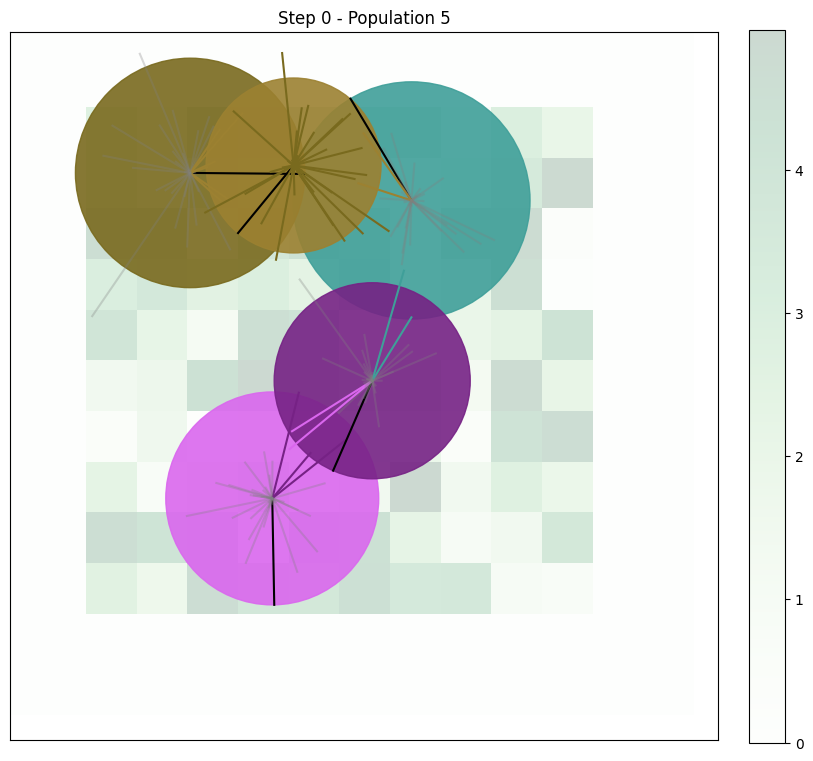

In [57]:
torch.random.manual_seed(96)
game = gworld.GWorld(config.simple_cfg())
ps = game.compute_grid_setup()
collisions = game.trace_rays_grid(*ps)
game.visualize(collisions)
# game.visualize_grid_setup(*ps, collisions)

In [53]:
ps[1]

tensor([[2, 3, 1],
        [3, 5, 2],
        [1, 2, 1]], device='cuda:0', dtype=torch.int32)

In [55]:
ps[0][..., 1]

tensor([[ 4,  3, -1],
        [ 3,  1,  1],
        [-1,  0, -1]], device='cuda:0', dtype=torch.int32)

In [49]:
ray_x, ray_y, ray_len = game.creatures.rays[2, 20]
print(ray_x, ray_y, ray_len)
ray = torch.tensor([ray_x, ray_y], device='cuda') * ray_len
game.creatures.positions[2] + ray

tensor(0.2766, device='cuda:0') tensor(-0.9610, device='cuda:0') tensor(2.2632, device='cuda:0')


tensor([7.7849, 4.7217], device='cuda:0')

# Visualize Grid Setup

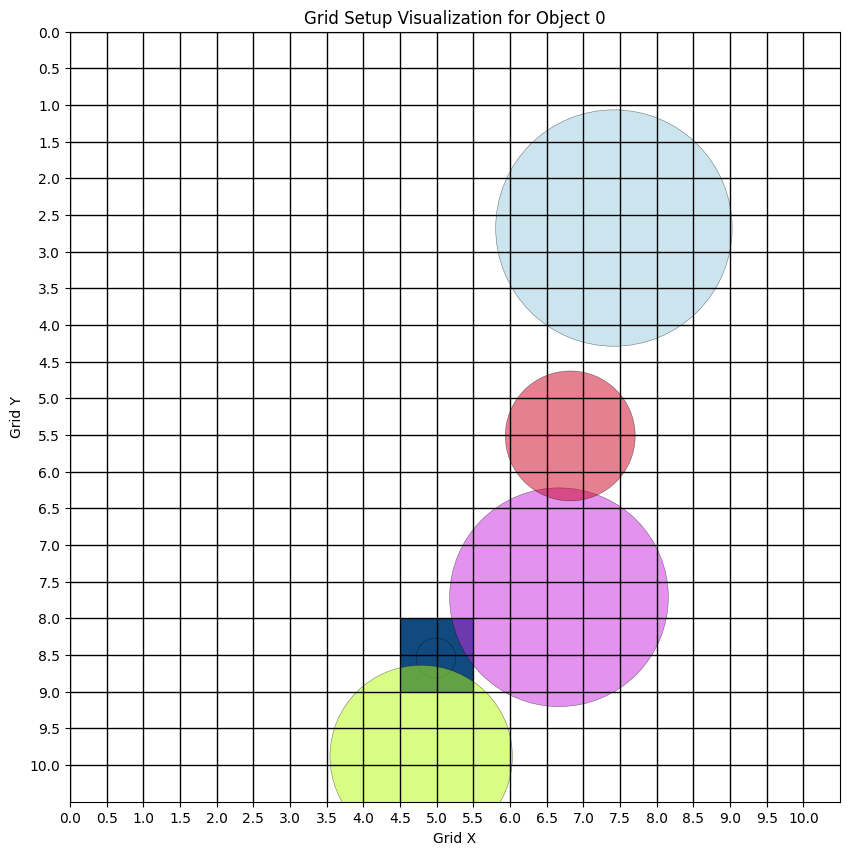

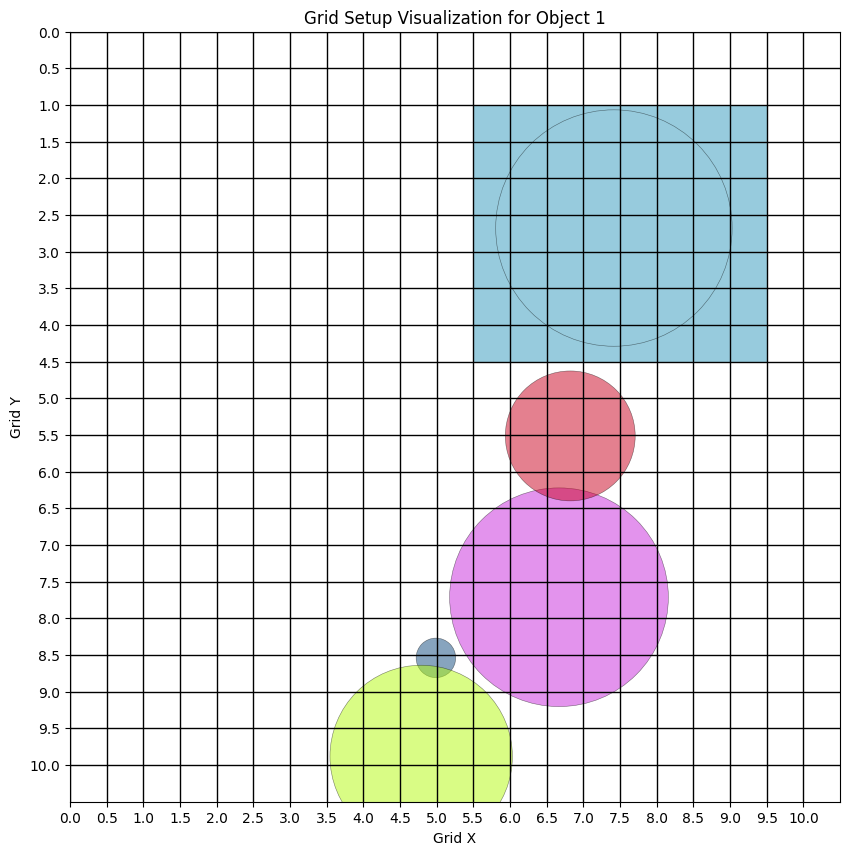

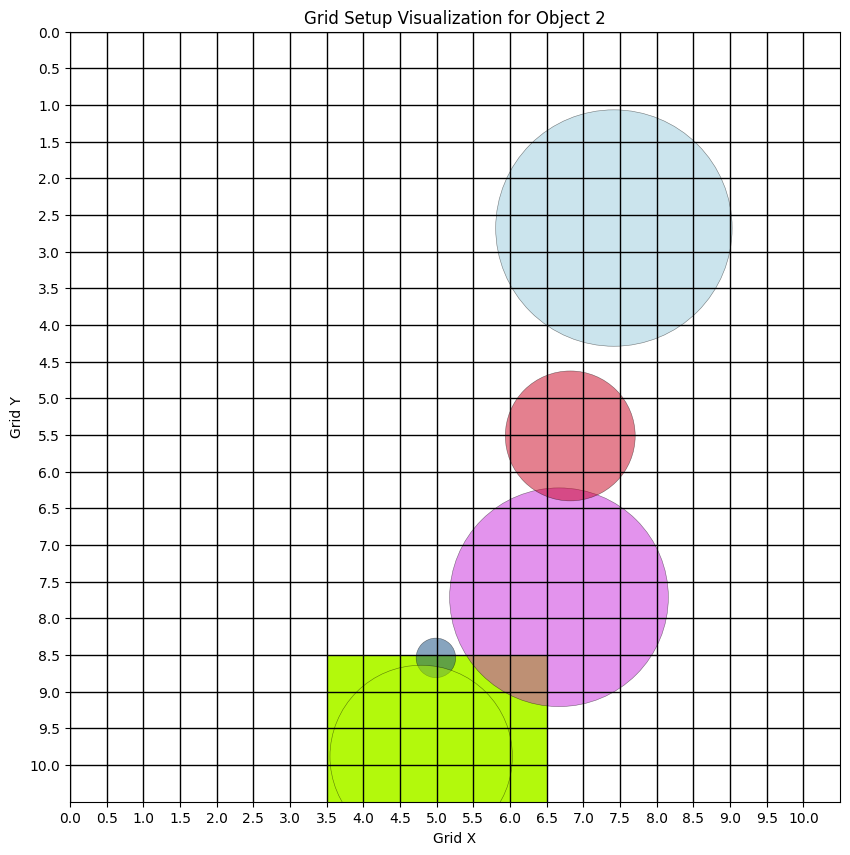

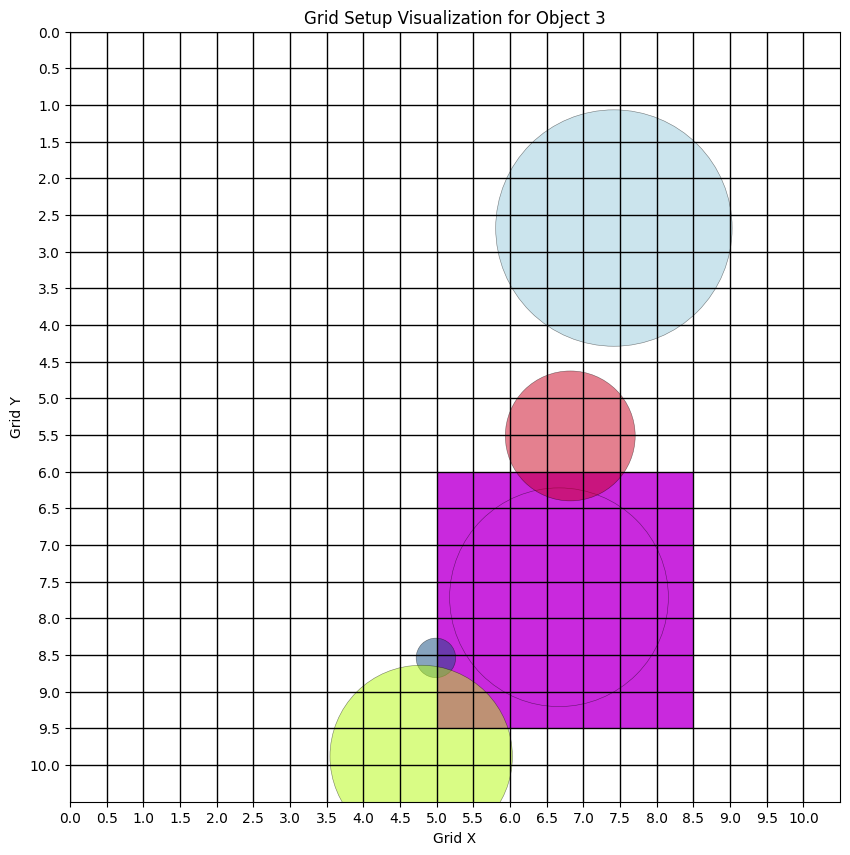

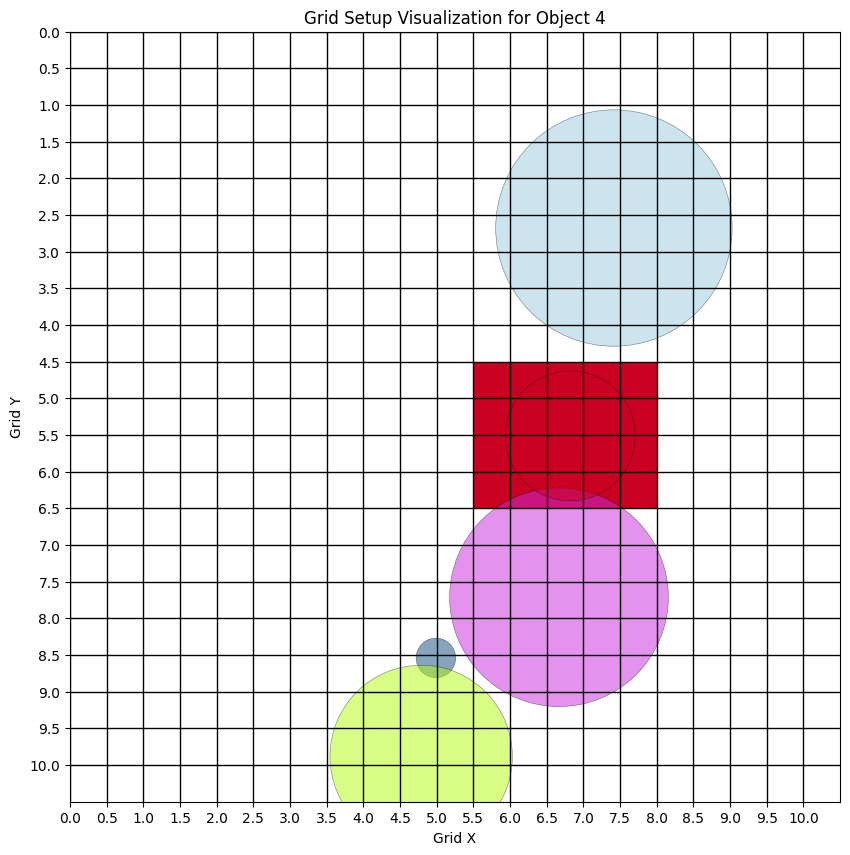

In [36]:
torch.random.manual_seed(101)
game = gworld.GWorld(config.simple_cfg(cell_size=0.5))
ps = game.compute_grid_setup()
game.visualize_grid_setup(*ps)

tensor([[2.9893, 6.5387],
        [5.4166, 0.6771],
        [2.7886, 7.8828],
        [4.6677, 5.7117],
        [4.8214, 3.5116]], device='cuda:0') tensor([0.2695, 1.6120, 1.2440, 1.4912, 0.8856], device='cuda:0')


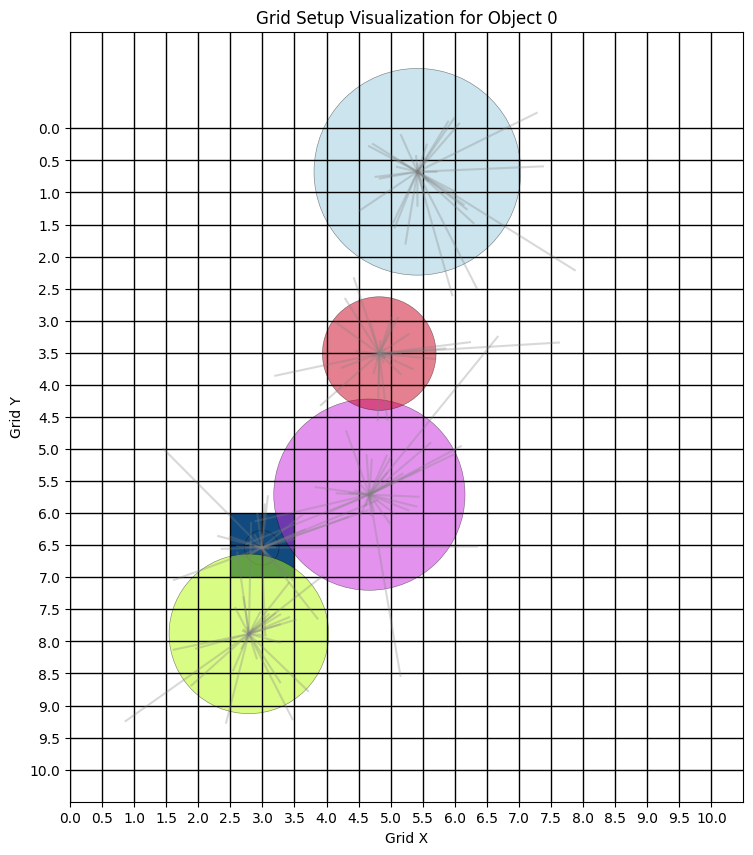

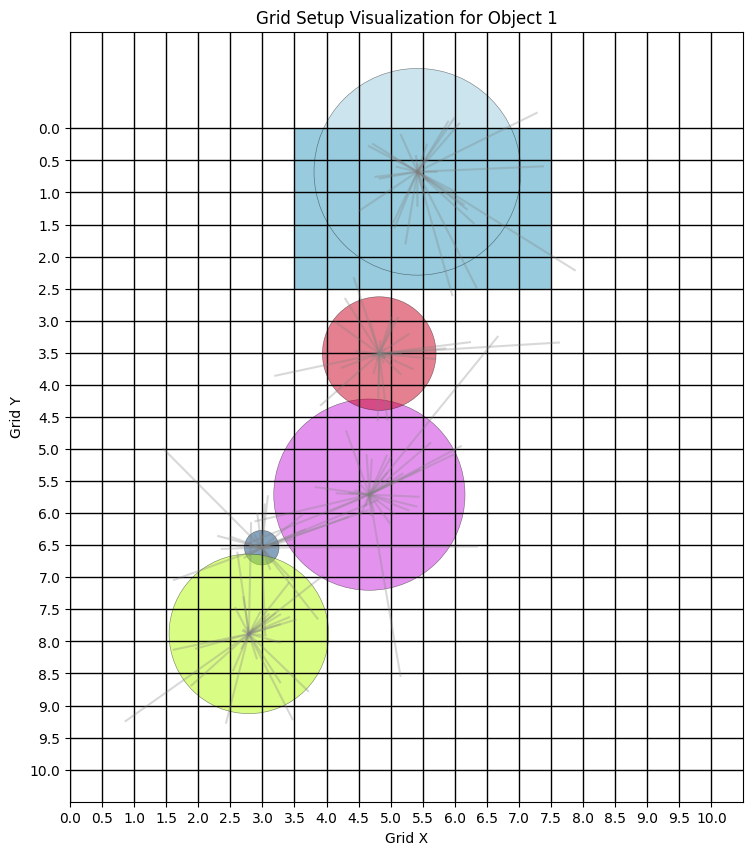

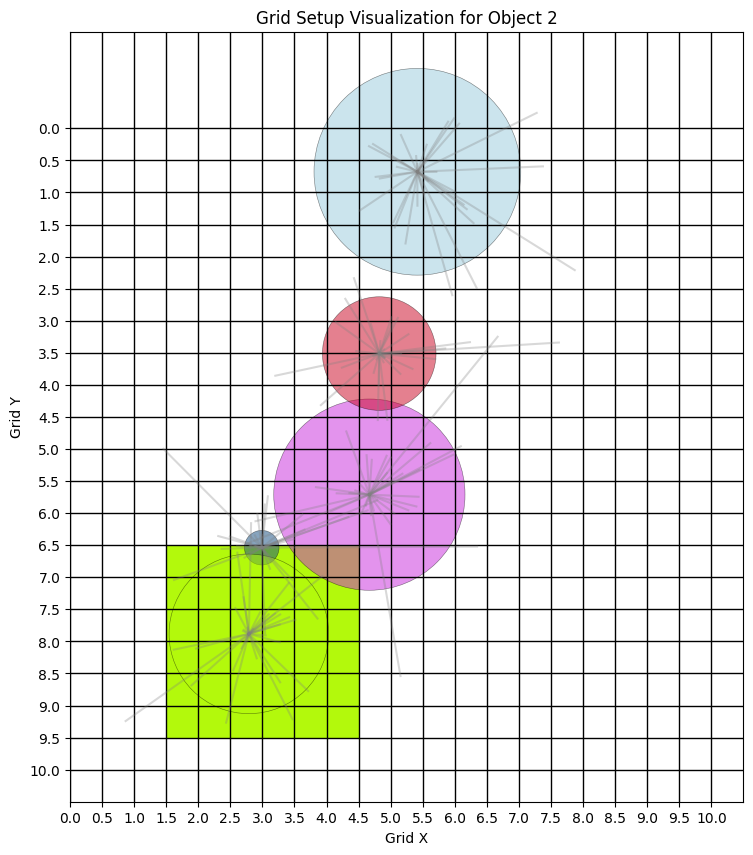

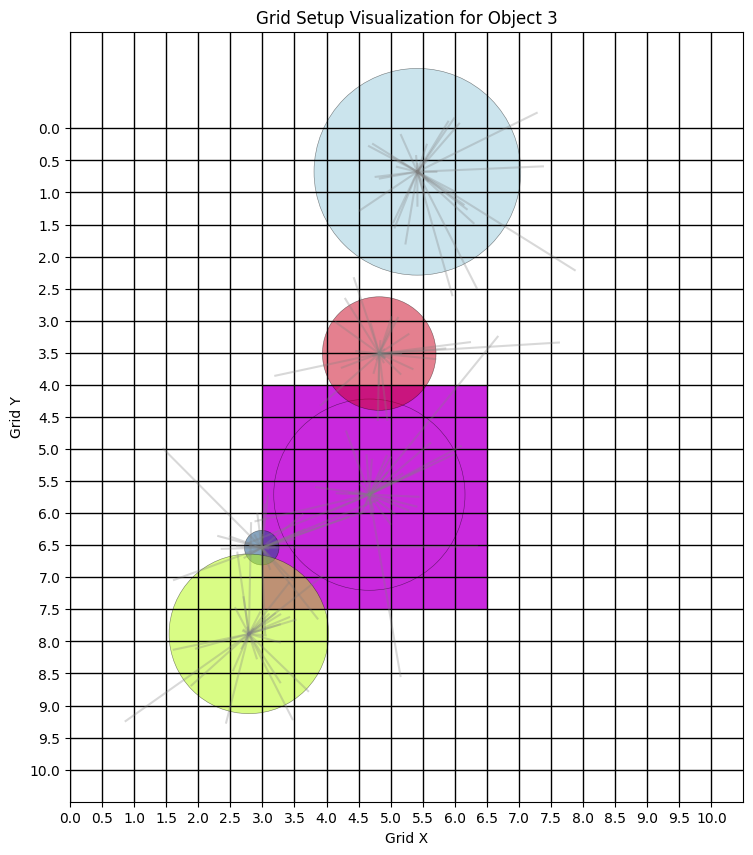

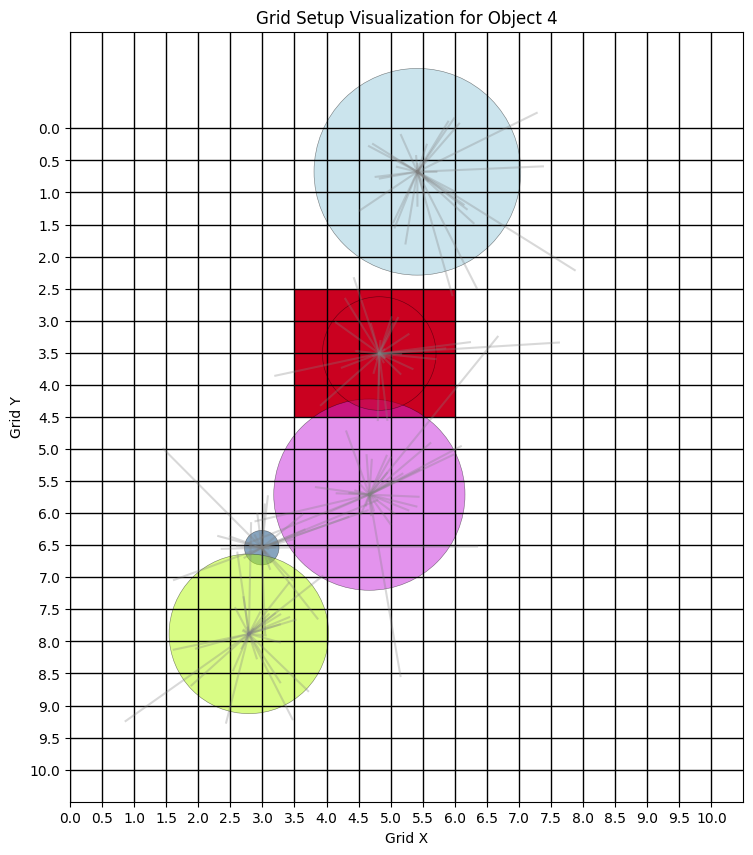

In [10]:
torch.random.manual_seed(101)
game = gworld.GWorld(config.simple_cfg(cell_size=0.5))
print(game.creatures.positions, game.creatures.sizes)
ps = game.compute_grid_setup()
game.visualize_grid_setup(*ps)

# Visualize Attacking

tensor([[2.0000, 0.0000],
        [0.0000, 8.4552],
        [0.0000, 0.0000],
        [1.0000, 0.3646],
        [0.0000, 0.3646]], device='cuda:0')


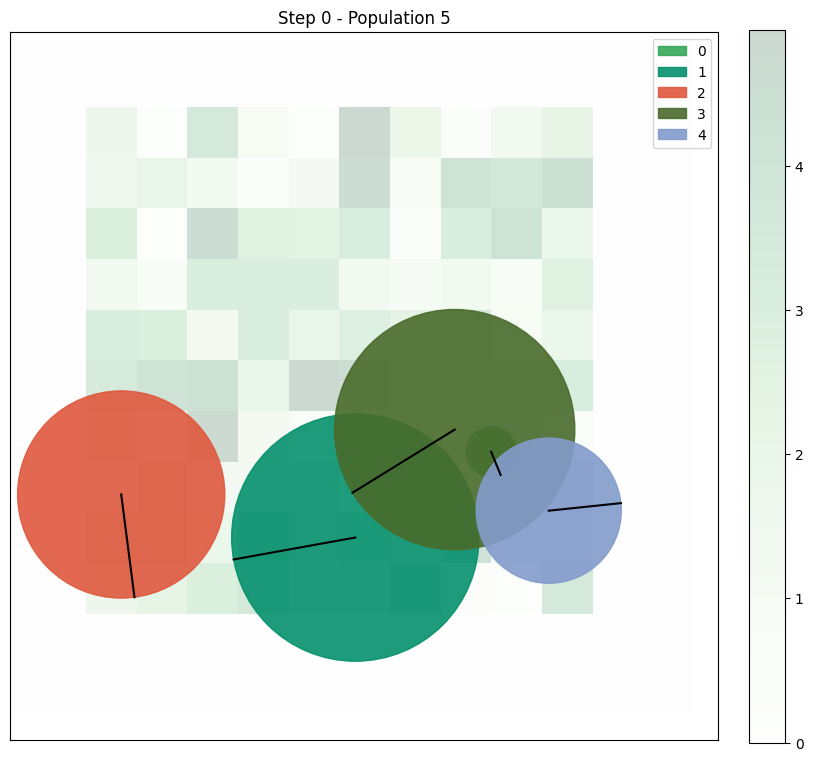

In [62]:
torch.random.manual_seed(100)
game = gworld.GWorld(config.simple_cfg(cell_size=0.5))
ps = game.compute_grid_setup()
attacks = game.compute_gridded_attacks(*ps)
print(attacks)
game.visualize(None, show_rays=False, legend=True)
# game.visualize_grid_setup(*ps, None, show_rays=False)

# Profiling Ray Trace Grid params

In [ ]:
results = gworld.main()

100%|██████████| 5/5 [1:03:30<00:00, 762.11s/it]


In [ ]:
results

{(32, 0.5): [(9485.290092479438, 1.796405392808989e-05),
  (9920.607007477432, 0.0),
  (10792.122985705733, 1.2974038948064922e-05),
  (10268.745408341289, 1.497004494007491e-05),
  (10107.311877567321, 1.996005992009988e-06),
  (9815.344007819891, 2.994008988014982e-06),
  (10181.369042087346, 9.98002996004994e-07),
  (9877.366012502462, 1.996005992009988e-06),
  (10395.265930909663, 0.0),
  (9198.595962829888, 3.3932101864169795e-05)],
 (32, 1.0): [(9505.16747840494, 2.295406890811486e-05),
  (10439.11065518111, 0.0),
  (9244.224867261946, 1.796405392808989e-05),
  (9968.505952976644, 0.0),
  (9708.24598710239, 8.982026964044946e-06),
  (10105.61969269067, 8.982026964044946e-06),
  (9901.353312678635, 2.994008988014982e-06),
  (10095.018876299262, 9.98002996004994e-06),
  (10535.901433221996, 0.0),
  (9098.385005049407, 3.8922116844194765e-05)],
 (32, 2.0): [(9431.673857666552, 2.495007490012485e-05),
  (10183.020421408117, 0.0),
  (9265.723426584154, 2.1956065912109868e-05),
  (1125

In [ ]:
avgd_results = {k: (np.median([el[0] for el in v]), np.mean([el[1] for el in v])) for k, v in results.items()}
var_results = {k: (np.std([el[0] for el in v]), np.std([el[1] for el in v])) for k, v in results.items()}
avgd_results, var_results

({(32, 0.5): (10013.959442522377, 8.782426364843947e-06),
  (32, 1.0): (9934.92963282764, 1.1077833255655432e-05),
  (32, 2.0): (9888.276320492849, 9.381228162446944e-06),
  (32, 3.0): (9976.580137193203, 7.784423368838953e-06),
  (32, 4.0): (9863.106801394373, 1.0381227164443946e-05),
  (32, 5.0): (9869.296695230529, 5.988017976029964e-06),
  (32, 8.0): (9984.856078946963, 8.782426364843947e-06),
  (64, 0.5): (9916.51675657928, 8.085820273632458e-06),
  (64, 1.0): (10095.008776329458, 7.990011986015977e-06),
  (64, 2.0): (9969.0174696967, 7.884223668439453e-06),
  (64, 3.0): (9892.332659460604, 8.784422370835954e-06),
  (64, 4.0): (9914.091240307316, 7.98601997403196e-06),
  (64, 5.0): (9916.569273473695, 9.481028462047443e-06),
  (64, 8.0): (9847.74948737491, 7.586818775629961e-06),
  (128, 0.5): (9791.215486645699, 9.281427862846444e-06),
  (128, 1.0): (9950.69156239368, 6.0878182756304634e-06),
  (128, 2.0): (9902.775355519727, 8.982026964044946e-06),
  (128, 3.0): (9909.5445653926

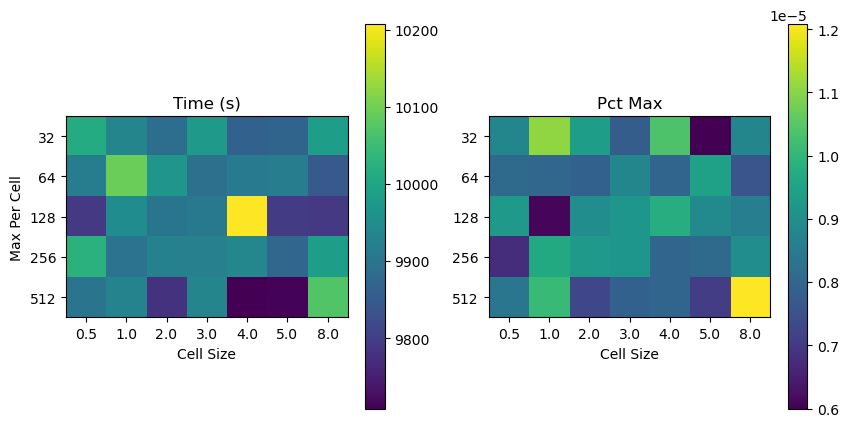

In [ ]:
# visualize results on 2D grid, doing 1 subplot for time (index 0) and 1 subplot for pct max (index 1)
# results is dictionary with entries being ('max_per_cell', 'cell_size'): 'time', 'pct_max'
# it should be a heatmap of the entries
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

key_value = list(avgd_results.items())
key_value.sort(key=lambda x: x[0])  # sort by key
# then do imshow
num_max_per_cell = len(set([x[0][0] for x in key_value]))
num_cell_size = len(set([x[0][1] for x in key_value]))

titles = ['Time (s)', 'Pct Max']
for i in range(2):
    time = np.array([x[1][i] for x in key_value])
    time = time.reshape((num_max_per_cell, num_cell_size))
    cax = ax[i].imshow(time, cmap='viridis')#, extent=[0, num_cell_size, 0, num_max_per_cell])
    plt.colorbar(cax, ax=ax[i])

    ax[i].set_xlabel('Cell Size')
    ax[i].set_title(titles[i])
    # set ticks and their labels
    ax[i].set_xticks(np.arange(0, num_cell_size, 1))
    ax[i].set_xticklabels(list(sorted(set([x[0][1] for x in key_value]))))
    if i == 0:
        ax[i].set_ylabel('Max Per Cell')
    ax[i].set_yticks(np.arange(0, num_max_per_cell, 1))
    ax[i].set_yticklabels(list(sorted(set([x[0][0] for x in key_value]))))

# best is max_per_cell = 512, cell_size = 4.0
# where time is lowest, and pct is bottom 5-ish

# Numba vs. Pytorch speed

In [ ]:
from numba import cuda, float32

# Controls threads per block and shared memory usage.
# The computation will be done on blocks of TPBxTPB elements.
TPB = 16

@cuda.jit
def fast_matmul(A, B, C):
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sA = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
    sB = cuda.shared.array(shape=(TPB, TPB), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.x    # blocks per grid

    if x >= C.shape[0] and y >= C.shape[1]:
        # Quit if (x, y) is outside of valid C boundary
        return

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = 0.
    for i in range(bpg):
        # Preload data into shared memory
        sA[tx, ty] = A[x, ty + i * TPB]
        sB[tx, ty] = B[tx + i * TPB, y]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(TPB):
            tmp += sA[tx, j] * sB[j, ty]

        # Wait until all threads finish computing
        cuda.syncthreads()

    C[x, y] = tmp

/home/rob/anaconda3/envs/jack/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 1000/1000 [00:00<00:00, 113614.43it/s]
/home/rob/anaconda3/envs/jack/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 1000/1000 [00:00<00:00, 114389.07it/s]
/home/rob/anaconda3/envs/jack/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 1000/1000 [00:00<00:00, 110913.48it/s]


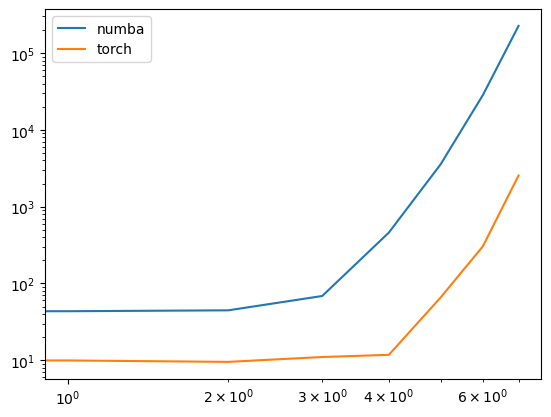

In [ ]:
import torch
torch.set_grad_enabled(False)
import time
import matplotlib.pyplot as plt
from tqdm import trange

@torch.no_grad()
def trial(size):
    x = np.random.rand(size, size).astype(np.float32)
    y = np.random.rand(size, size).astype(np.float32)
    z = np.zeros((size, size)).astype(np.float32)

    d_x = cuda.to_device(x)
    d_y = cuda.to_device(y)
    d_z = cuda.to_device(z)

    t_x = torch.from_numpy(x).cuda()
    t_y = torch.from_numpy(y).cuda()

    threadsperblock = (TPB, TPB)
    blockspergrid_x = int(np.ceil(x.shape[0] / threadsperblock[0]))
    blockspergrid_y = int(np.ceil(y.shape[1] / threadsperblock[1]))
    blockspergrid = (blockspergrid_x, blockspergrid_y)
    # print(blockspergrid, threadsperblock)
    fast_matmul[blockspergrid, threadsperblock](d_x, d_y, d_z)
    # np_res = x @ y
    torch_res = t_x @ t_y
    # print((torch_res*100).int())
    # # print(np_res)
    # # print(z)
    # print((d_z.copy_to_host()*100).astype(np.int32))
    # print(((d_z.copy_to_host() - torch_res.cpu().numpy())**2).sum())
    # return

    trials = 1_000
    res = {}

    start = cuda.event(timing=True)
    end = cuda.event(timing=True)
    start.record()
    for _ in trange(trials):
        fast_matmul[blockspergrid, threadsperblock](d_x, d_y, d_z)
    cuda.synchronize()
    end.record()
    end.synchronize()
    res['numba'] = cuda.event_elapsed_time(start, end)

    # start = time.time()
    # for _ in trange(trials):
    #     x @ y
    # res['numpy'] = time.time() - start

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    for _ in trange(trials):
        t_x @ t_y
    end.record()
    torch.cuda.synchronize()
    res['torch'] = start.elapsed_time(end)

    return res

full_res = {'numba': [], 'torch': []}#, 'numpy': []}
for size in [32, 64, 128, 256, 512, 1024, 2048, 4096]:
    res = trial(size)
    for key in res:
        full_res[key].append(res[key])

plt.plot(full_res['numba'], label='numba')
# plt.plot(full_res['numpy'], label='numpy')
plt.plot(full_res['torch'], label='torch')
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [ ]:
full_res

{'numba': [46.73030471801758,
  43.433982849121094,
  44.609535217285156,
  68.57686614990234,
  459.62384033203125,
  3553.339599609375,
  28329.9921875,
  226221.890625],
 'torch': [10.38640022277832,
  9.923583984375,
  9.5065279006958,
  11.000767707824707,
  11.745087623596191,
  65.47110748291016,
  303.6805114746094,
  2544.28076171875]}